# Ice Volume, Thickness, and Bedrock Elevation

In [1]:
# Load xarray and gcfs
import xarray as xr
import gcsfs
gcs = gcsfs.GCSFileSystem(token=None, access='read_only')

In [2]:
# Load larger data, "snapshots1ka", which has more variables and contains more spatial fields
snapshots1ka = xr.open_zarr(gcs.get_mapper('gs://ldeo-glaciology/paleo_ensemble/snapshots1ka.zarr'))
snapshots1ka = snapshots1ka.chunk(chunks={'time':1})

In [3]:
snapshots1ka

,Array,Chunk
Bytes,17.30 GiB,35.44 MiB
Shape,"(125, 381, 381, 4, 4, 4, 4)","(1, 381, 381, 1, 4, 4, 4)"
Count,3 Graph Layers,500 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,17.30 GiB,35.44 MiB
Shape,"(125, 381, 381, 4, 4, 4, 4)","(1, 381, 381, 1, 4, 4, 4)"
Count,3 Graph Layers,500 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [4]:
# Add these codes to decrease CPU and memory use, which avoids the workers from being killed.
from dask.distributed import Client
import dask_gateway

gateway = dask_gateway.Gateway()

# Close existing clusters
open_clusters = gateway.list_clusters()
print(list(open_clusters))
if len(open_clusters)>0:
    for c in open_clusters:
         cluster = gateway.connect(c.name)
         cluster.shutdown()  

# Increase worker memory
options = gateway.cluster_options()
options.worker_memory = 16

cluster = gateway.new_cluster(cluster_options=options)

[ClusterReport<name=prod.2bfcdf72ecf647309175be7f05589217, status=RUNNING>]


In [5]:
# Start up cloud cluster with 20 workers
cluster.scale(20)
client = Client(cluster)

In [6]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.4281a5089790414f8f861e3e2e1197ff/status,


At first, compute the mean ice volume at each time step across the ensemble.

In [7]:
# Sum ice thickness over x and y dimensions, and multiply by the cell area
cellArea = snapshots1ka.x.attrs['spacing_meters'] * snapshots1ka.y.attrs['spacing_meters']

In [8]:
# Preprocess data for ice volume
V = (snapshots1ka.thk.where(snapshots1ka.mask == 2).sum(['x','y'])*cellArea)

In [9]:
# Compute the mean volume at each time step across the ensemble
Vmean = V.mean({'par_esia','par_ppq','par_prec','par_visc'})
Vmean.attrs['units'] = 'm^3'
Vmean.attrs['long_name'] = 'mean volume'
Vmean.time.attrs['long_name'] = 'simulation time'
Vmean.time.attrs['units'] = 'years BP'
Vmean.name = 'mean volume'

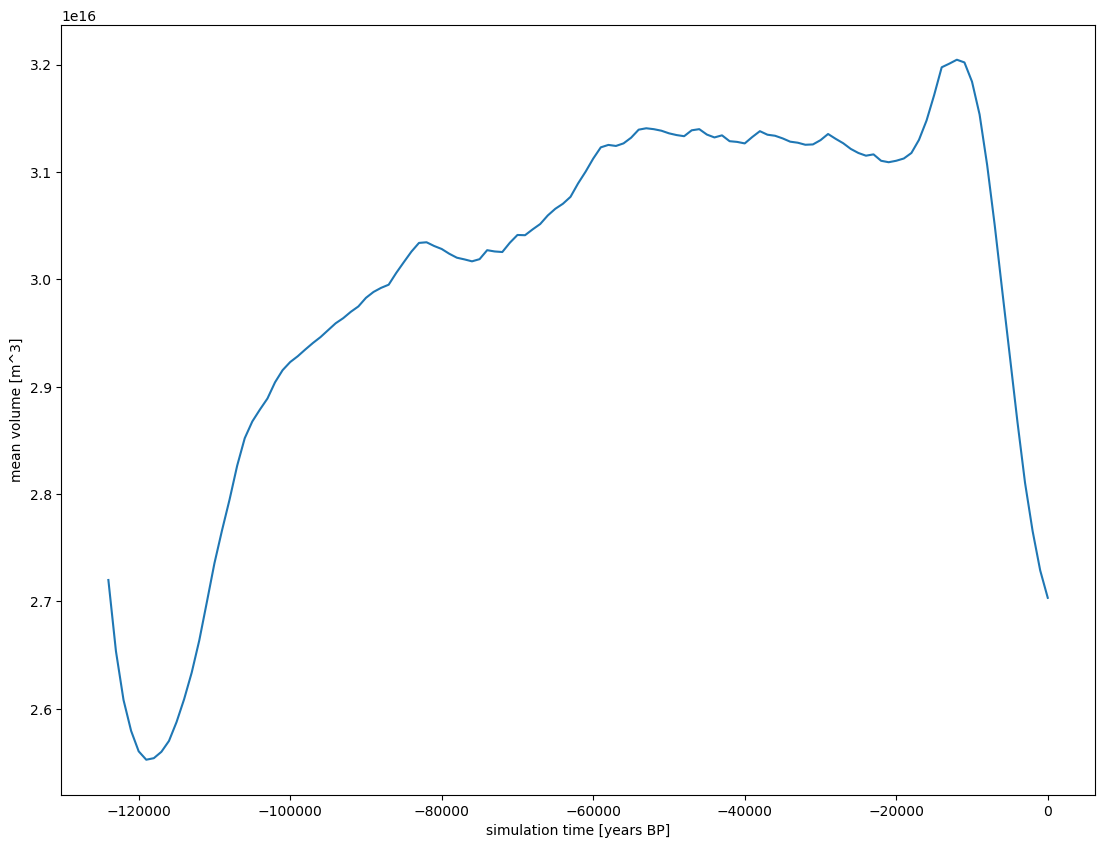

In [10]:
Vmean.plot(size=10)

Next, compute mean ice thickness at each time step across the ensemble.

In [15]:
# Preprocess data for ice thickness
T = (snapshots1ka.thk.where(snapshots1ka.mask == 2))

In [16]:
# Compute the mean thickness at each time step across the ensemble
Tmean = T.mean({'par_esia','par_ppq','par_prec','par_visc','x','y'})
Tmean.attrs['units'] = 'm'
Tmean.attrs['long_name'] = 'mean thickness'
Tmean.time.attrs['long_name'] = 'simulation time'
Tmean.time.attrs['units'] = 'years BP'
Tmean.name = 'mean thickness'

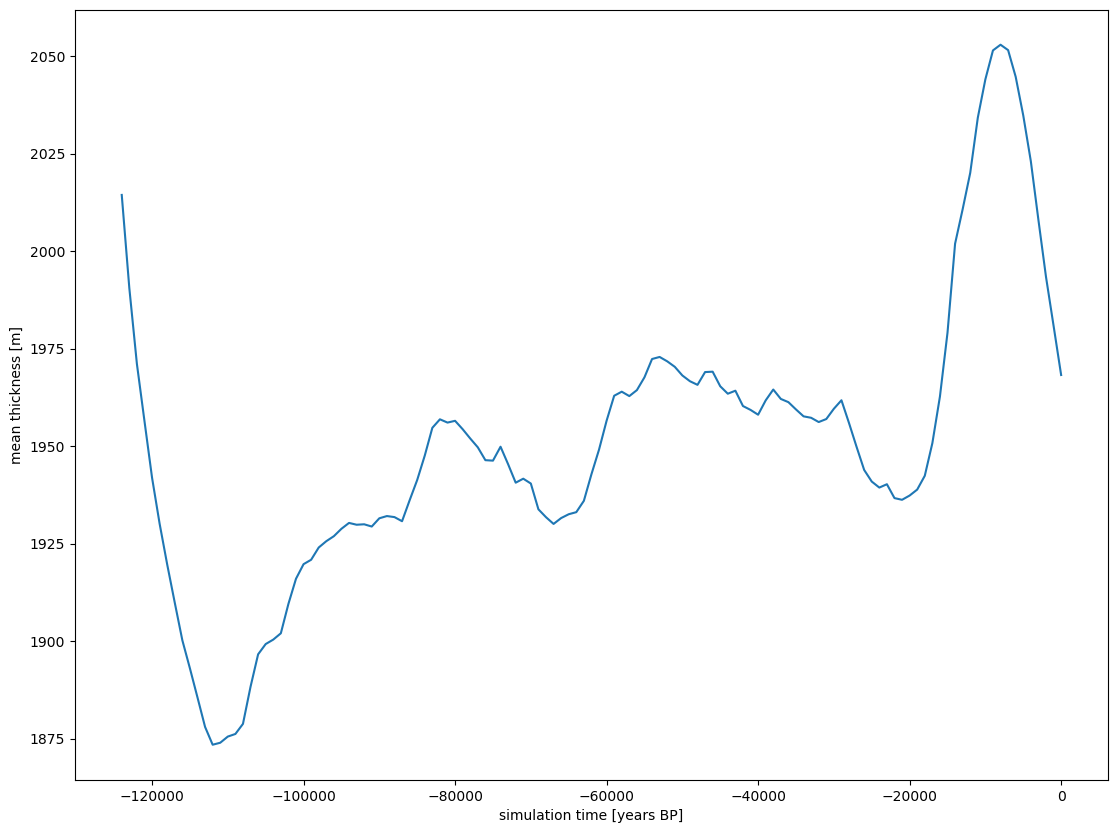

In [17]:
Tmean.plot(size=10)

Lastly, compute mean bedrock topography at each time step across the ensemble.

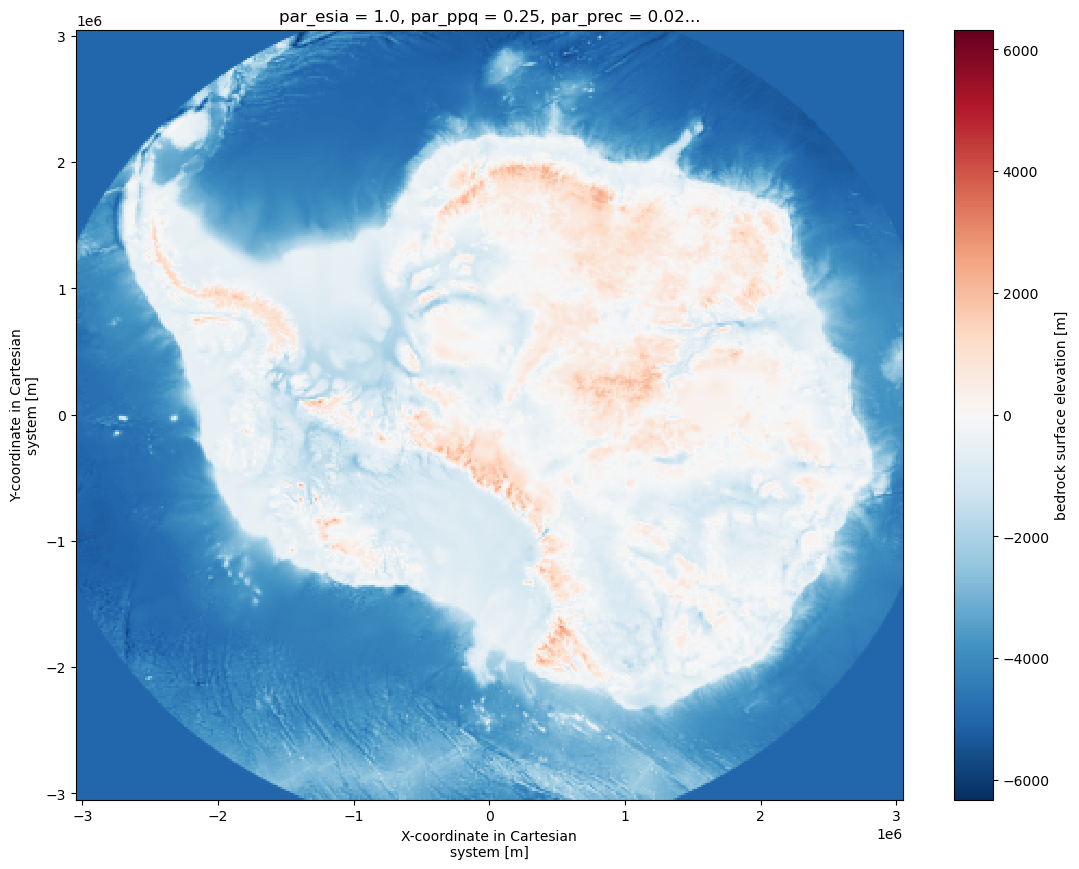

In [29]:
# Bedrock topography for present day for the combination:
# (par_esia= 1.0, par_ppq = 0.25, par_prec= 0.02, par_visc = 1e+20).
snapshots1ka.topg.isel(par_esia= 0,par_ppq = 0, par_prec= 0,par_visc = 0, time=124).plot(size = 10)

In [22]:
# Preprocess data for bedrock topography
G = (snapshots1ka.topg.where(snapshots1ka.mask == 2))

In [23]:
Gmean = G.mean({'par_esia','par_ppq','par_prec','par_visc','x','y'})
Gmean.attrs['units'] = 'm'
Gmean.attrs['long_name'] = 'mean topography'
Gmean.time.attrs['long_name'] = 'simulation time'
Gmean.time.attrs['units'] = 'years BP'
Gmean.name = 'mean topography'

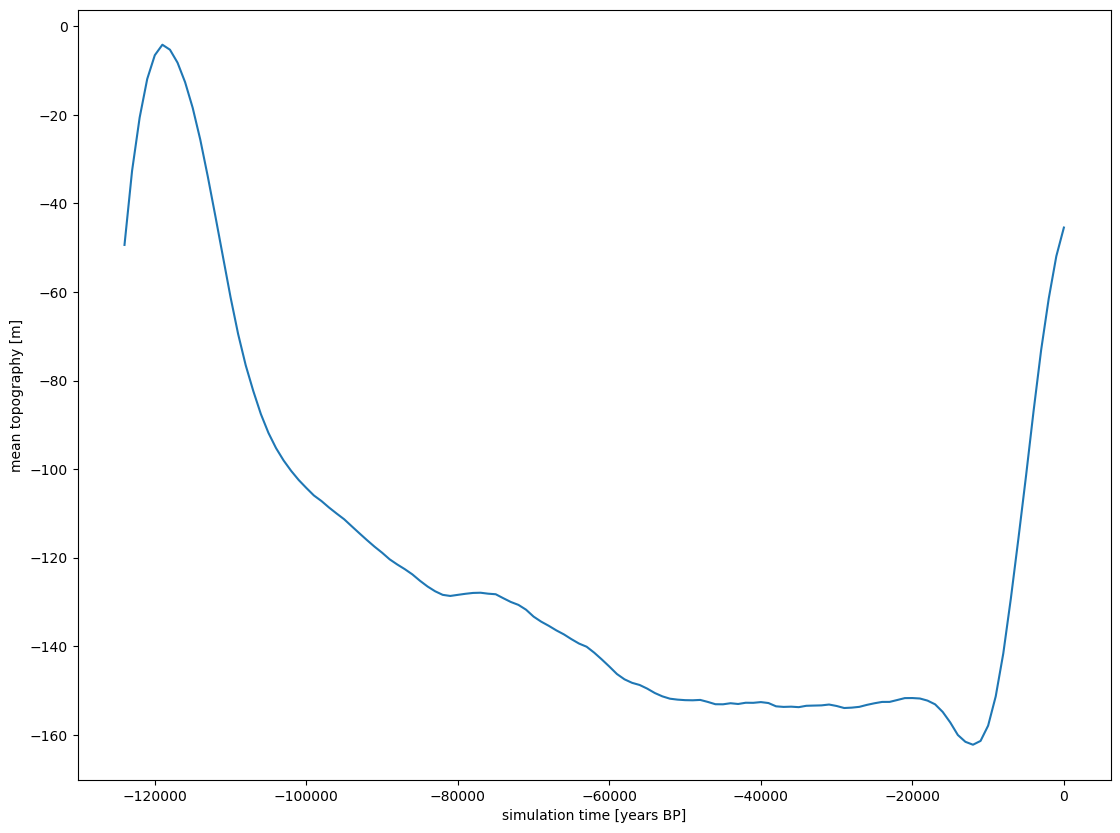

In [21]:
Gmean.plot(size=10)

In [30]:
cluster.shutdown()

2022-11-11 18:51:02,457 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
